In [132]:
import pandas as pd
import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
# load data
with open('./data/breast-cancer-info.txt','r') as file:
    labels = [line.rstrip() for line in file]

df = pd.read_csv("./data/breast-cancer.csv",names=labels)
df.head(6)

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
5,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,left,left_low,no


In [142]:
skew = df.Class.value_counts()

no-recurrence-events    201
recurrence-events        85
Name: Class, dtype: int64

In [133]:
class Node:
    def __init__(self, name):
        self.attribute_name = name
        self.children = {}
    def create_child(self, attribute_value, node):
        self.children[attribute_value] = node
    def is_leaf(self):
        return len(self.children) == 0

    def __str__(self, level=0):
        ret = "ATTRIBUTE_NAME:"+self.attribute_name+"\n"
        for attr_val, child in self.children.items():
            ret += "\t"*level+"ATTRIBUTE_VALUE:"+str(attr_val) + " " + child.__str__(level+1)
        return ret

        
class ID3:
    def __init__(self, k = None):
        self.X = None
        self.classes = None
        self.features = None
        self.splitting_options = None
        self.tree = None
        self.min_samples_split = k
    
    def entropy(self, subset):
        n = subset.shape[0]
        pi = subset.y.value_counts() / n
        return -np.sum(pi*np.log(pi))
    
    def ig(self, subset, attr):
        n = subset.shape[0]
        split_entropy = 0
        for cat in subset[attr].unique():
            cat_subset = subset[subset[attr]==cat]
            split_entropy = split_entropy + cat_subset.shape[0]*self.entropy(cat_subset)
        
        return self.entropy(subset) - split_entropy/n

    def split(self, subset):
        best = max(self.splitting_options,key=lambda attr: self.ig(subset,attr))
        self.splitting_options = self.splitting_options.drop(best)
        categories = subset[best].unique()
        categories = np.append(categories,None)
        return best, tuple([(cat,subset[subset[best]==cat]) for cat in categories])
    
    def is_pure(self, subset):
        x = [pred for (pred, count) in zip(subset.y.unique(), subset.y.value_counts()) if count > 0]
        if len(x) == 1:
            return x[0]
        else:
            return False
    
    def max_class(self, subset):
        return subset.y.value_counts().idxmax()

    def fit(self, X, y):
        self.X = pd.concat([X,y.rename('y')],axis=1)
        self.classes = y.unique()
        self.features = X.columns
        self.splitting_options = self.features

        # Node : attribute name
        # Node children: [{'attribute_value': Node}, {'attribute_value': Node},  ]
        # Leaf : prediction class
        # traversal: 
        self.tree = self.build_tree(self.X)
    
    def build_tree(self, subset, parent_subset=None):
        if subset.shape[0] == 0:
            # If there are no examples in the subset, then a leaf node is 
            # # created and labelled with the most common class of the examples in the parent node's set.
            return Node(self.max_class(parent_subset))
            
        if len(self.splitting_options) == 0 or subset.shape[0] < self.min_samples_split:
            return Node(self.max_class(subset))
        
        if pred := self.is_pure(subset):
            return Node(pred)
        
        attr_name, splits = self.split(subset)

        node = Node(attr_name)
        for (attr_value, new) in splits:
            node.create_child(attr_value,self.build_tree(new,subset))
        
        return node
        
    def predict(self, x):
        current = self.tree
        while (not current.is_leaf()):
            value = x[current.attribute_name]
            if value not in current.children:
                value = None
            current = current.children[value]
    
        return current.attribute_name

    

In [134]:
import sys
def accuracy(pred,actual):
    return np.sum(pred.to_numpy()==actual.to_numpy()) / actual.shape[0]
def macro_f1(pred,actual):

    def f1_score(pred, actual, positive_class):
        is_positive_pred = pred == positive_class
        is_positive_actual = actual == positive_class
        tp = np.sum(np.logical_and(is_positive_actual, is_positive_pred))
        if tp == 0:
            return 0

        tp_fn = np.sum(is_positive_actual)
        tp_fp = np.sum(is_positive_pred)

        if tp_fp == 0 or tp_fn == 0:
            return 0

        precision = tp / tp_fp
        recall = tp / tp_fn
        return 2*((precision*recall)/(precision+recall))
    # precision = tp / (tp+fp)
    # recall = tp / (tp+fn)
# +--------------+-------+------------------+
# | -            |       | predicted value  |
# +--------------+-------+-------+----------+
# |              |       | bc    | no-bc    |
# |              +-------+-------+----------+
# | actual value | bc    | tp    | fn       |
# |              +-------+-------+----------+
# |              | no-bc | fp    | tn       |
# +--------------+-------+-------+----------+
    a,b = 'recurrence-events', 'no-recurrence-events'
    return (f1_score(pred,actual,a) + f1_score(pred,actual,b)) / 2

    return 2*(precision*recall)/(precision+recall)
def CV(model, X, y, k = 10, method=accuracy):
    
    
    n = X.shape[0]
    inds = np.arange(0,n)
    np.random.shuffle(inds)
    folds = np.array_split(inds,k) # k groups of size l//(n+1) or l//n

    batches = []
    for i, test in enumerate(folds): #(one group, k-1 group) == (test, train)
        train = np.concatenate(np.delete(folds,i)).ravel()
        batches.append((test, train))
    
    scores = []
    training_scores = []
    for test, train in batches:
        X_train, y_train, X_test, y_test = X.iloc[train], y.iloc[train], X.iloc[test], y.iloc[test]
        model.fit(X_train, y_train)

        y_pred = pd.Series([model.predict(x) for _,x in X_test.iterrows()])
        score = method(y_pred,y_test)
        scores.append(score)

        y_train_pred=pd.Series([model.predict(x) for _,x in X_train.iterrows()])
        training_score = method(y_train_pred,y_train)
        training_scores.append(training_score)
    
    avg_score = np.average(scores)
    avg_training_score = np.average(training_scores)
    return avg_score, scores, avg_training_score, training_scores

In [135]:
X, y = df.iloc[:,1:], df.iloc[:,0]

In [136]:
clf = ID3(20)
avg_score, scores, _, _= CV(clf, X, y, method=macro_f1)

In [149]:
min_samples_splits, acc, training_acc = [], [], []
for k in range(0,105,5):
    min_samples_splits.append(k)
    test_score, _,train_score, _  = CV(ID3(k), X, y, k=5, method=macro_f1)
    acc.append(test_score)
    training_acc.append(train_score)


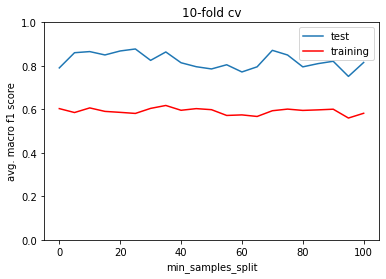

In [150]:
import matplotlib.pyplot as plt
plt.ylim(0,1)
plt.plot(min_samples_splits,acc,label='test')
plt.plot(min_samples_splits, training_acc, label='training',color='red')
plt.xlabel("min_samples_split")
plt.ylabel("avg. macro f1 score")
plt.legend()
plt.title("10-fold cv");

In [146]:
min_samples_splits, acc, training_acc = [], [], []
for k in range(0,105,5):
    min_samples_splits.append(k)
    test_score, _,train_score, _  = CV(ID3(k), X, y, k=5, method=accuracy)
    acc.append(test_score)
    training_acc.append(train_score)

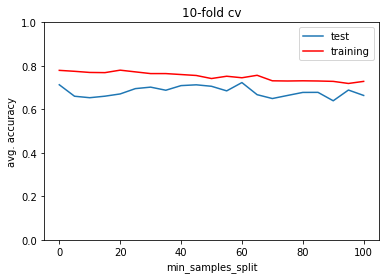

In [147]:
import matplotlib.pyplot as plt
plt.ylim(0,1)
plt.plot(min_samples_splits,acc,label='test')
plt.plot(min_samples_splits, training_acc, label='training',color='red')
plt.xlabel("min_samples_split")
plt.ylabel("avg. accuracy")
plt.legend()
plt.title("10-fold cv");